In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile 
from datetime import datetime
import random
import spacy
from bs4 import BeautifulSoup
from collections import Counter
import itertools

%matplotlib inline

# Data Collection

In [2]:
with zipfile.ZipFile('Data/train.csv.zip') as zipf:
    with zipf.open('train.csv') as myZip:
        preprocessed_train = pd.read_csv(myZip) 
        
with zipfile.ZipFile('Data/valid.csv.zip') as zipf:
    with zipf.open('valid.csv') as myZip:
        preprocessed_valid = pd.read_csv(myZip) 

# Data Checking

In [3]:
# Checking whether training and validation datasets are mutually exclusive

check =  any(item in preprocessed_valid['Id'] for item in preprocessed_train['Id'])
print(f'Check whether the validation dataset contains some elements of training dataset: {check}')

Check whether the validation dataset contains some elements of training dataset: False


In [4]:
# combining both data frames together
preprocessed_data = pd.concat([preprocessed_train, preprocessed_valid], ignore_index=True)
preprocessed_data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [5]:
print(f'Check whether the data has any NaN values: {preprocessed_data.isnull().any().any()}')

Check whether the data has any NaN values: False


In [6]:
print(f'Number of Columns                             : {preprocessed_train.shape[1]}')
print(f'Number of questions in the Training dataset   : {preprocessed_train.shape[0]}')
print(f'Number of questions in the validation dataset : {preprocessed_valid.shape[0]}')

Number of Columns                             : 6
Number of questions in the Training dataset   : 45000
Number of questions in the validation dataset : 15000


In [7]:
# Selecting a body of a random question to view it before preprocessing

n = len(preprocessed_data.index)
ind = random.sample(range(n), 1)[0]

print(f'Question Id selected: {ind} \n -----')
print(preprocessed_data.loc[ind, 'Body'])

Question Id selected: 52114 
 -----
In my database website, I added a way where a user can do a quick search for a specific record in a database. I also added a will paginate, but when I did, the search bar didn't work. How can I fix this?

my controller

    class VendorsController < ApplicationController
        def index
            @vendors = Vendor.search(params[:search])
        
            @vendors = Vendor.all.paginate(page: params[:page], per_page: 10)
        
        end

    #...
    end



index 


    #...
    <table>
        <tr>
                 <% if user_signed_in? %>    
                 <%= button_to "New Vendor", new_vendor_path, :method => "get" %>
                 <% end %>
       
               <%= button_to "Inventory", inventories_path, :method => "get" %>
                
                 <%= form_tag vendors_path, :method => "get" do %>
                <%= text_field_tag :search, params[:search] %>
                <%= submit_tag "Search", :contact_name => 

# Data Processing

In [8]:
# !python -m spacy download en_core_web_lg

In [9]:
%%time

nlp = spacy.load("en_core_web_lg", disable=["parser", "ner", "tagger"])

def text_tokenizer(text):
    doc = nlp(text)
    result = [token.lemma_ for token in doc if token.lemma_.isalpha() and not token.is_stop]
    return result

def code_tokenizer(text):
    doc = nlp(text)
    result = [token.lemma_ for token in doc if token.lemma_.isalpha()]
    return result

def get_text(text):
    """
    This is to extract only the text part of the question body
    """
    soup = BeautifulSoup(text)
    if soup.code:
        soup.code.clear()
        question = soup.get_text() 
    else:
        question = soup.get_text() 
    return ' '.join(text_tokenizer(question))

def get_code(text):
    """
    This is to extract only the code part of the question body
    """
    soup = BeautifulSoup(text)
    code = soup.code.text if soup.code else ''
    return ' '.join(code_tokenizer(code))

def get_body(text):
    """
    This will treat the whole question body as one unit (text and code) and extract the text from it
    """
    soup = BeautifulSoup(text)
    body = soup.get_text() 
    return ' '.join(text_tokenizer(body))

def process_SOFdata(df):
    """
    This will take the SOF data frame and process existing columns (Title, Body and Tags) and 
    create new columns (Body_text and Body_code) and then return the processed data frame
    """
    processed_df = pd.DataFrame()
    processed_df['Title'] = df['Title'].apply(get_text)
    processed_df['Body'] = df['Body'].apply(get_body)
    processed_df['Body_text'] = df['Body'].apply(get_text)
    processed_df['Body_code'] = df['Body'].apply(get_code)
    processed_df['Tags'] = df['Tags'].apply(lambda x: x[1:-1].split('><'))
    return processed_df

Wall time: 3.68 s


In [10]:
%%time

processed_data = process_SOFdata(preprocessed_data)

Wall time: 4min 56s


In [11]:
processed_data.head()

,Title,Body,Body_text,Body_code,Tags
0,Java Repeat Task Random Seconds,familiar repeat task n second Timer TimerTask ...,familiar repeat task n second Timer TimerTask ...,,"[java, repeat]"
1,Java Optionals immutable,like understand Java Optionals design immutabl...,like understand Java Optionals design immutabl...,,"[java, optional]"
2,Text Overlay Image Darkened Opacity React Native,attempt overlie title image image darken low o...,attempt overlie title image image darken low o...,for article preview touchable image will requi...,"[javascript, image, overlay, react-native, opa..."
3,ternary operator swift picky,question simple find answer return x Hello com...,question simple find answer compile return x H...,return x Hello,"[swift, operators, whitespace, ternary-operato..."
4,hide fab scale animation,custom floatingactionmenu need implement scale...,custom floatingactionmenu need implement scale...,,"[android, material-design, floating-action-but..."


### Before and After

In [12]:
print(f'id#{ind} Body before processing: \n', '-'*40, '\n', preprocessed_data.Body[ind], '\n ..'*4)
print(f'id#{ind} Body code after processing: \n', '-'*40, '\n', processed_data.Body[ind])
# print(', '.join(map(repr, train.loc[ind,'Body'])))

id#27875 Body before processing: 
 ---------------------------------------- 
 <p>So, I'm building an console application that has a List of objects. </p>

<ul>
<li><p>Every 1000ms, a "producer" is doing a HTTP request and creating a new object from the result, and adds it to the List of objects.</p></li>
<li><p>Every 1000ms, a "consumer" is going analysing through all the objects in the list.</p></li>
<li><p>Every 2000ms, another "consumer" is going analysing through all the objects in the list.</p></li>
<li><p>Every 3500ms, another "consumer" is going analysing through all the objects in the list.</p></li>
</ul>

<p>Once in a while, at arbitrary times, I want to ask one of the consumers what the result of this analysed data is. </p>

<p>So this sounds like a classic producer / consumer pattern. In JavaScript this wouldn't be a problem, since it's nonblocking. But how about C#? I would assume this could be quite a concurrency nightmare. As far as I can understand, this cannot be done s

# EDA

In [13]:
def get_SOFstats(df):
    
    n = len(df.index)
    
    title_count = df['Title'].map(len)
    body_count = df['Body'].map(len)
    text_count = df['Body_text'].map(len)
    code_count = df['Body_code'].map(len)
    tags_count = df['Tags'].map(len)

    count = pd.concat([title_count, body_count, text_count, code_count, tags_count], axis=1, keys=['Title', 'Body', 'Body Text', 'Body Code', 'Tags'])
    # count = pd.concat([title_count, body_count, tags_count], axis=1, keys=['Title', 'Body', 'Tags'])
    print('Summary statistics')
    return count.describe(include='all')

In [14]:
%%time

pd.set_option('display.float_format', lambda x: '%.2f' % x)
get_SOFstats(processed_data)

Summary statistics
Wall time: 83.8 ms


,Title,Body,Body Text,Body Code,Tags
count,60000.00,60000.00,60000.00,60000.00,60000.00
mean,34.60,317.18,272.86,49.90,2.66
std,14.44,424.96,377.58,197.79,1.21
min,0.00,0.00,0.00,0.00,1.00
25%,25.00,118.00,103.00,0.00,2.00
50%,33.00,204.00,176.00,0.00,3.00
75%,42.00,366.00,310.00,25.00,3.00
max,140.00,20281.00,20281.00,14726.00,6.00


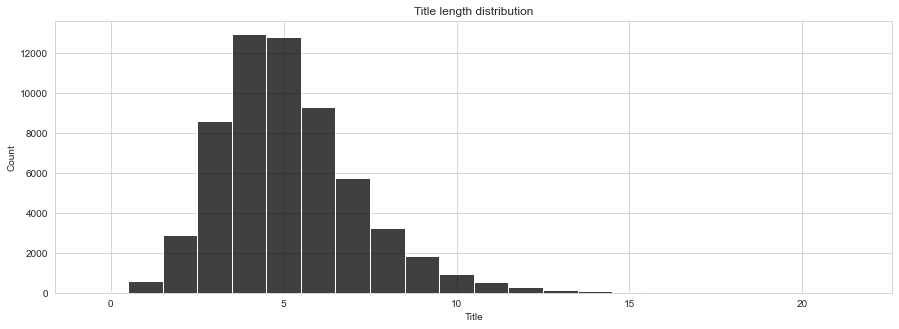

In [15]:
title_length = processed_data['Title'].apply(lambda x: len(x.split()))
body_length = processed_data['Body'].apply(lambda x: len(x.split()))

plt.rcParams["figure.figsize"] = (15,5)
sns.set_style('whitegrid')
sns.histplot(title_length, discrete=True, color='black').set_title('Title length distribution');

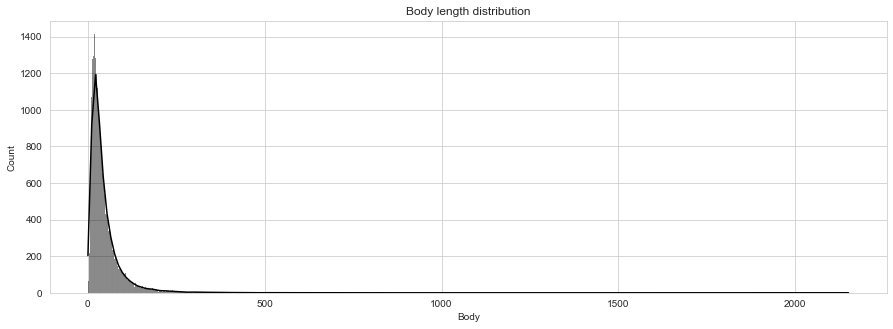

In [16]:
sns.histplot(body_length, discrete=True, kde=True, color='black').set_title('Body length distribution');

In [17]:
def get_corpus(df, feature):   
    corpus = []

    for row in df[feature].str.split():
        for word in row:
            corpus.append(word)
    corpus = sorted(Counter(corpus).items(), key = lambda x:x[1], reverse = True)
    return corpus

feature = 'Title'
title_corpus = get_corpus(df=processed_data, feature=feature)
feature = 'Body_text'
text_corpus = get_corpus(df=processed_data, feature=feature)
feature = 'Body_code'
code_corpus = get_corpus(df=processed_data, feature=feature)

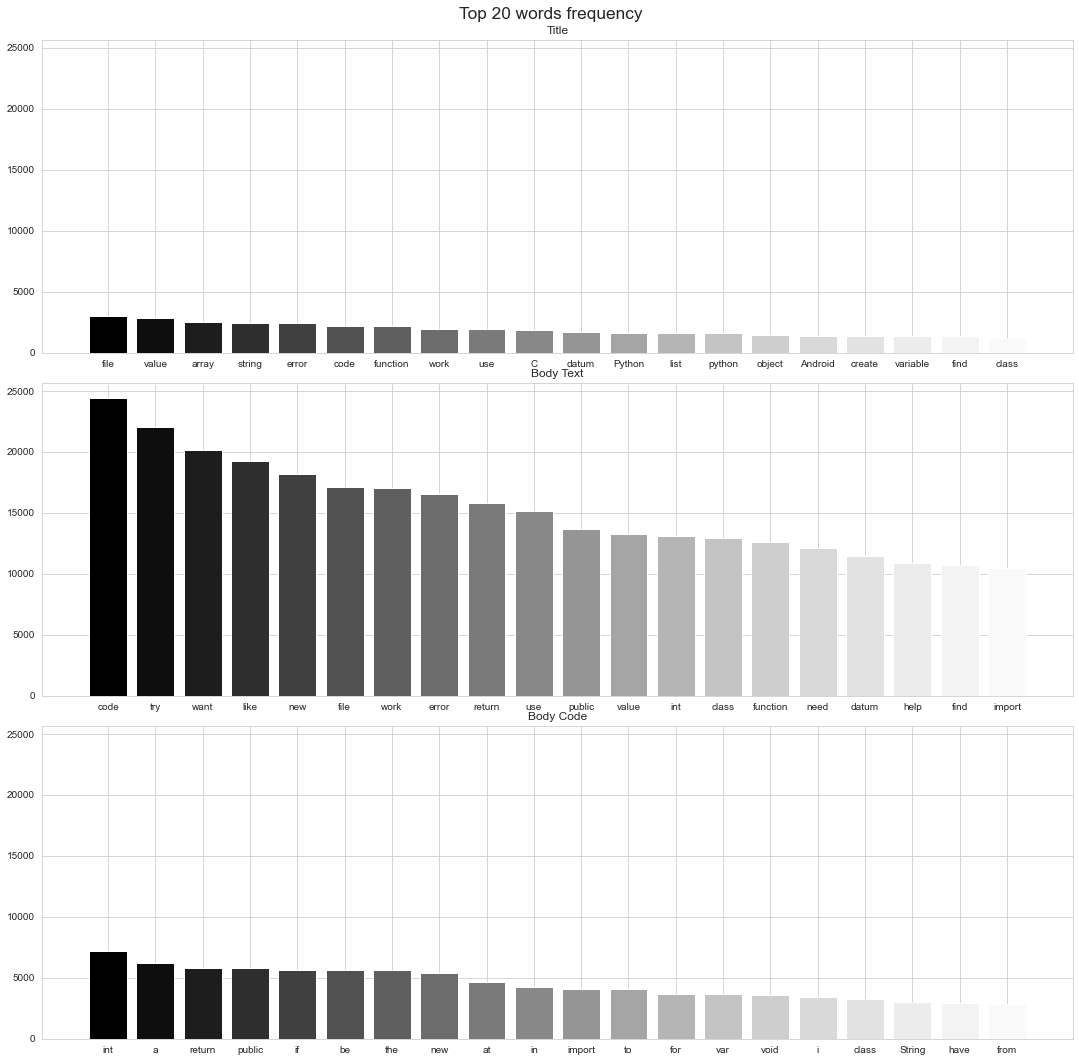

In [18]:
selected_words = 20
color = plt.cm.Greys(np.linspace(1, 0, selected_words+1))

fig, ax = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(15, 15))
plt.grid()
st = fig.suptitle(f"Top {selected_words} words frequency", fontsize="xx-large")
fig.tight_layout()
fig.subplots_adjust(top=0.95);
top_words, top_values = zip(*title_corpus[:selected_words])
ax[0].bar(top_words, top_values, color=color)
ax[0].title.set_text('Title')
top_words, top_values = zip(*text_corpus[:selected_words])
ax[1].bar(top_words, top_values, color=color)
ax[1].title.set_text('Body Text')
top_words, top_values = zip(*code_corpus[:selected_words])
ax[2].bar(top_words, top_values, color=color)
ax[2].title.set_text('Body Code')
plt.grid();

In [19]:
def tags_stats(df):
    n = len(df.index)
    tags = [df.loc[i,'Tags'] for i in range(n)]
#     tags = [df.loc[i,'Tags'].split(' ') for i in range(n)]
    num_tags = [len(i) for i in tags]
    tags = list(itertools.chain.from_iterable(tags))
    unique_tags = set(tags)
    return tags, num_tags, unique_tags

In [20]:
tags, num_tags, unique_tags = tags_stats(processed_data)
print(f"Total number of tags  : {len(tags)}")
print(f"Number of unique tags : {len(unique_tags)}")

Total number of tags  : 159880
Number of unique tags : 10703


In [21]:
card = len(tags) / len(processed_data)
print(card)
dens = card / len(unique_tags)
print(dens)

2.6646666666666667
0.00024896446479180293


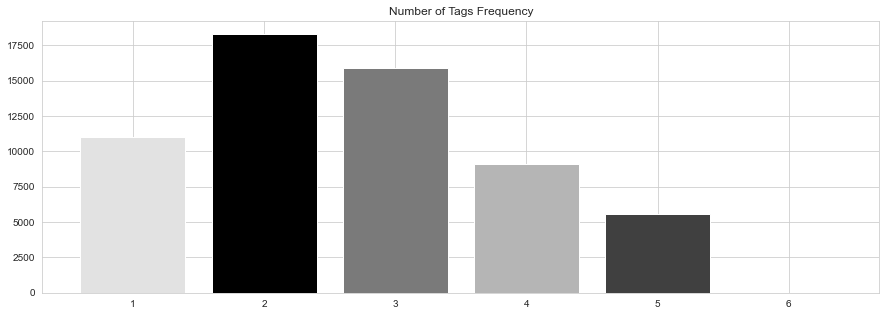

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
import operator

color = plt.cm.Greys(np.linspace(1, 0, 6))
num_count = Counter(num_tags)
plt.rcParams["figure.figsize"] = (15,5)
plt.bar(num_count.keys(), num_count.values(), color=color)
plt.grid()
plt.title("Number of Tags Frequency")
plt.grid(); #no idea why I need to 2 plt.grid to show the grids

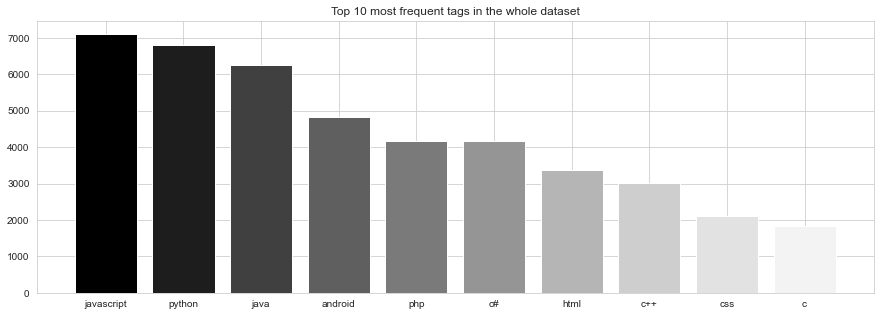

In [23]:
tag_count = Counter(tags) 
sorted_tags = {k: v for k, v in sorted(tag_count.items(), key=lambda item: item[1], reverse=True)}
common_tags = dict(tag_count.most_common(10))

color = plt.cm.Greys(np.linspace(1, 0, 11))
plt.bar(common_tags.keys(), common_tags.values(), color=color)
plt.grid()
plt.title("Top 10 most frequent tags in the whole dataset")
plt.grid();

In [24]:
selected_tags = 50
other_tags = tag_count.most_common()[-(len(tag_count)-selected_tags):]
other_tags_value = sum([i[1] for i in other_tags])

labels = [tag[0] for tag in tag_count.most_common(selected_tags)] + ['Other Tags']
values = [tag[1] for tag in tag_count.most_common(selected_tags)] + [other_tags_value]

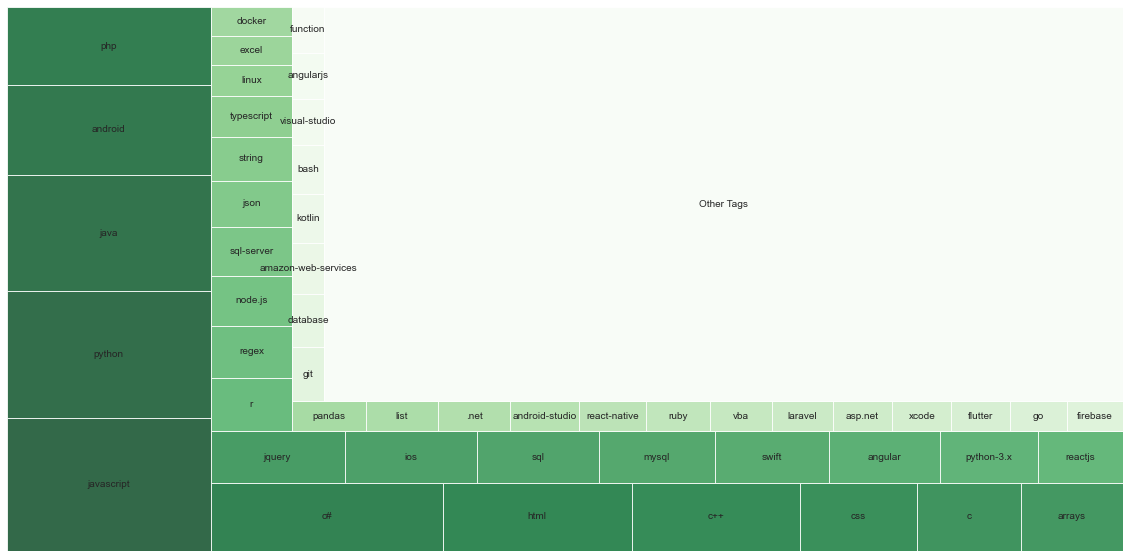

Wall time: 257 ms


In [25]:
%%time
import squarify

plt.figure(figsize = (20,10))
color = plt.cm.Greens(np.linspace(1, 0, selected_tags+1))
squarify.plot(sizes = values, label = labels , alpha = .8, color = color)
# plt.title('Tree Map showing the size of common tags')
plt.axis('off')
plt.show()

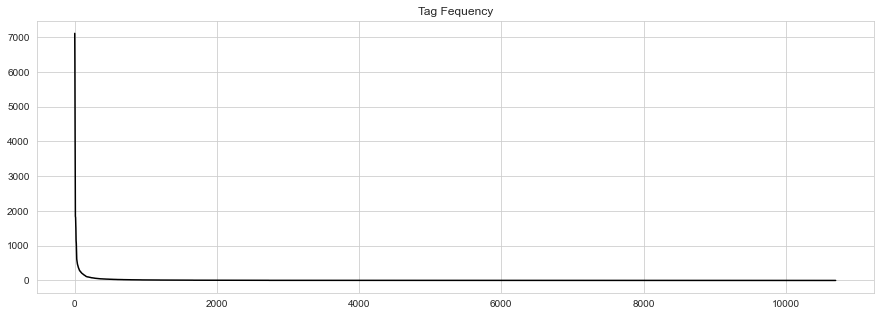

In [26]:
plt.plot(sorted(tag_count.values(), reverse=True), color='black')
plt.grid()
plt.title("Tag Fequency")
plt.grid();

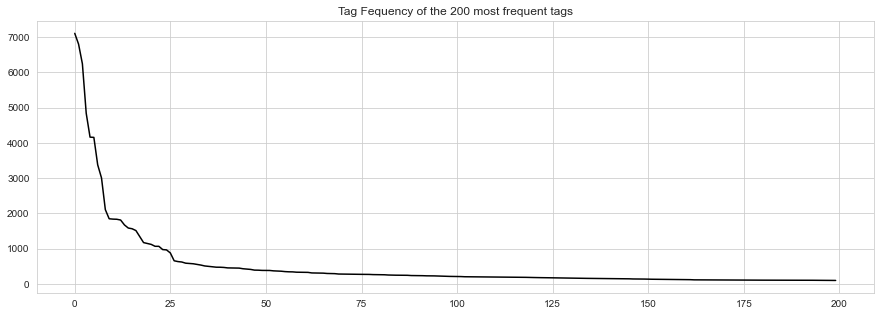

In [27]:
plt.plot(sorted(tag_count.values(), reverse=True)[0:200], color='black');
plt.grid()
plt.title("Tag Fequency of the 200 most frequent tags")
plt.grid();

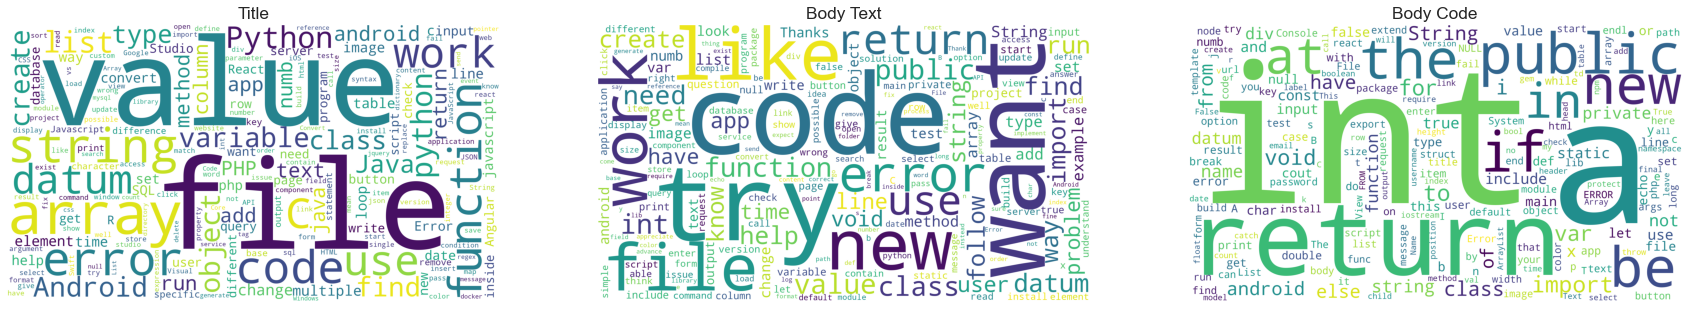

In [28]:
from wordcloud import WordCloud

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))
wc_1 = WordCloud(background_color = 'white', width=2560, height=1440)
wc_1.generate_from_frequencies(dict(title_corpus))
ax[0].imshow(wc_1)
ax[0].set_title('Title', fontsize="xx-large")
ax[0].axis('off');

wc_2 = WordCloud(background_color = 'white', width=2560, height=1440)
wc_2.generate_from_frequencies(dict(text_corpus))
ax[1].imshow(wc_2)
ax[1].set_title('Body Text', fontsize="xx-large")
ax[1].axis('off');

wc_3 = WordCloud(background_color = 'white', width=2560, height=1440)
wc_3.generate_from_frequencies(dict(code_corpus))
ax[2].imshow(wc_3)
ax[2].set_title('Body Code', fontsize="xx-large")
ax[2].axis('off');

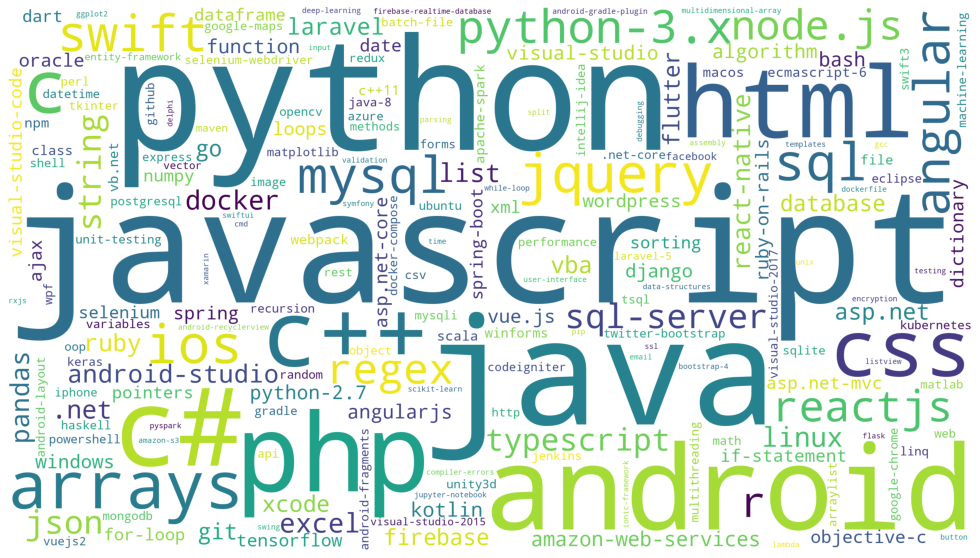

In [29]:
wc = WordCloud(background_color = 'white', width=2560, height=1440)
wc.generate_from_frequencies(tag_count)

plt.figure(figsize = (20,10))
plt.imshow(wc)
plt.axis('off') 
plt.show()

# Multi-Label Classification

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report, hamming_loss, jaccard_score, accuracy_score, f1_score, precision_score, recall_score, \
                            confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, label_ranking_loss, plot_roc_curve

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain

In [31]:
def select_labels(data, num_labels):
    common_tags = list(map(lambda x: x[0], tag_count.most_common(num_labels)))       
    data['Tags'] = [[x for x in i if x in common_tags] for i in data['Tags']]
    return data

In [32]:
%%time

num_labels = 200
df = select_labels(processed_data, num_labels)

mlb = MultiLabelBinarizer()
X = df[['Title', 'Body','Body_text', 'Body_code']]
y = mlb.fit_transform(df['Tags'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Wall time: 272 ms


In [33]:
df.head()

,Title,Body,Body_text,Body_code,Tags
0,Java Repeat Task Random Seconds,familiar repeat task n second Timer TimerTask ...,familiar repeat task n second Timer TimerTask ...,,[java]
1,Java Optionals immutable,like understand Java Optionals design immutabl...,like understand Java Optionals design immutabl...,,[java]
2,Text Overlay Image Darkened Opacity React Native,attempt overlie title image image darken low o...,attempt overlie title image image darken low o...,for article preview touchable image will requi...,"[javascript, image, react-native]"
3,ternary operator swift picky,question simple find answer return x Hello com...,question simple find answer compile return x H...,return x Hello,[swift]
4,hide fab scale animation,custom floatingactionmenu need implement scale...,custom floatingactionmenu need implement scale...,,[android]


In [34]:
%%time

transformer = FeatureUnion([
                ('title_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['Title'], validate=False)),
                            ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.8, min_df=0.0001, max_features=10_000, ngram_range=(1,3)))])),
                ('body_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['Body'], validate=False)),
                            ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.8, min_df=0.0001, max_features=10_000, ngram_range=(1,3)))]))]) 

X_train_2f = transformer.fit_transform(X_train)
X_test_2f = transformer.transform(X_test)

Wall time: 13.9 s


In [35]:
%%time

transformer = FeatureUnion([
                ('title_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['Title'], validate=False)),
                            ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.8, min_df=0.0001, max_features=10_000, ngram_range=(1,3)))])),
                ('body_text_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['Body_text'], validate=False)),
                            ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.8, min_df=0.0001, max_features=10_000, ngram_range=(1,3)))])),
                ('body_code_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['Body_code'], validate=False)),
                            ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.8, min_df=0.0001, max_features=10_000, ngram_range=(1,3)))]))]) 

X_train_3f = transformer.fit_transform(X_train)
X_test_3f = transformer.transform(X_test)

Wall time: 15.3 s


In [36]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
             
def get_scores(y_true, y_pred, clf, start_time, end_time, col_name):
    num_decimals = 4
    
    if clf.__class__.__name__ == 'LogisticRegression':
        cls_name = clf.__class__.__name__ + ": " + clf.get_params().get('penalty') + ", " + clf.get_params().get('solver')
    elif clf.__class__.__name__ == 'LinearSVC':
        cls_name = clf.__class__.__name__ + ": " + clf.get_params().get('penalty')
    elif clf.__class__.__name__ == 'SGDClassifier':
        if clf.get_params().get('loss') == 'log':
            cls_name = 'LogisticRegression: ' + clf.get_params().get('penalty') + ', sgd'
        if clf.get_params().get('loss') == 'hinge':
            cls_name = 'LinearSVC: ' + clf.get_params().get('penalty') + ', sgd'
    else:
        cls_name = clf.__class__.__name__

    hamming = round(hamming_loss(y_true, y_pred), num_decimals)
    accuracy = round(accuracy_score(y_true, y_pred), num_decimals)
    jaccard = round(jaccard_score(y_true, y_pred, average='samples'), num_decimals)
    time_spent = end_time - start_time 

    score_list = [cls_name, time_spent, hamming, accuracy, jaccard]
    for metric in ['samples', 'micro', 'macro', 'weighted']:
        score_list.append(round(precision_score(y_true, y_pred, average = metric, zero_division=0), num_decimals))
        score_list.append(round(recall_score(y_true, y_pred, average = metric, zero_division=0), num_decimals))
        score_list.append(round(f1_score(y_true, y_pred, average = metric, zero_division=0), num_decimals))
    
    cls_scores = pd.DataFrame([score_list], columns=col_names)
    cls_scores['Time Spent (s)'] = cls_scores['Time Spent (s)'].dt.total_seconds()
    return cls_scores

In [37]:
def classify(features, classifiers_list, MLC, col_names):
    scores_table = pd.DataFrame(columns=col_names)
    
    for classifier in classifiers_list:
        start_time = datetime.now()

        clf = MLC(classifier, require_dense=[False, True])
        clf.fit(features[0], y_train)
        y_pred = clf.predict(features[1])

        end_time = datetime.now()

        cls_scores = get_scores(y_test, y_pred, classifier, start_time, end_time, col_names)
        scores_table = scores_table.append(cls_scores, ignore_index=True)
    return scores_table, y_pred

In [38]:
nb  = MultinomialNB()
lr_l1  = LogisticRegression(penalty='l1', solver='saga', max_iter = 10_000)
lr_l2  = LogisticRegression(penalty='l2', solver='lbfgs', max_iter = 10_000)
sgd_l1 = SGDClassifier(loss='log', alpha=0.00001, penalty='l1', early_stopping=True, max_iter = 10_000)
sgd_l2 = SGDClassifier(loss='log', alpha=0.00001, penalty='l2', early_stopping=True, max_iter = 10_000)
svc_l1 = LinearSVC(C=1.5, penalty = 'l1', dual=False, max_iter = 10_000)
svc_l2 = LinearSVC(C=1.5, penalty = 'l2', dual=False, max_iter = 10_000)
sgd_svc1 = SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1', early_stopping=True, max_iter = 10_000)
sgd_svc2 = SGDClassifier(loss='hinge', alpha=0.00001, penalty='l2', early_stopping=True, max_iter = 10_000)
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [39]:
classifiers = [nb, sgd_l2, sgd_svc2]
col_names = ["Model Name", "Time Spent (s)", "Hamming Loss", "Subset Accuracy", "Jaccard Similarity", 
             "Precision", "Recall", "F1 Score", 
             "Micro Precision", "Micro Recall", "Micro F1 Score", 
             "Macro Precision", "Macro Recall", "Macro F1 Score", 
             "Weighted Precision", "Weighted Recall", "Weighted F1 Score"]

In [40]:
BinaryRelvance_2f, _ = classify(features=[X_train_2f, X_test_2f], classifiers_list=classifiers, MLC=BinaryRelevance, col_names=col_names)

In [41]:
BinaryRelvance_2f.to_csv('Results/BinaryRelevance_2f.csv')
BinaryRelvance_2f

,Model Name,Time Spent (s),Hamming Loss,Subset Accuracy,Jaccard Similarity,Precision,Recall,F1 Score,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Weighted Precision,Weighted Recall,Weighted F1 Score
0,MultinomialNB,2.62,0.01,0.20,0.28,0.40,0.30,0.32,0.76,0.29,0.43,0.36,0.08,0.11,0.61,0.29,0.37
1,"LogisticRegression: l2, sgd",29.25,0.01,0.30,0.43,0.57,0.47,0.49,0.80,0.46,0.58,0.67,0.31,0.41,0.75,0.46,0.56
2,"LinearSVC: l2, sgd",24.85,0.01,0.31,0.46,0.61,0.52,0.53,0.75,0.51,0.61,0.63,0.38,0.46,0.70,0.51,0.58


In [42]:
ClassifierChain_2f, _ = classify(features=[X_train_2f, X_test_2f], classifiers_list=classifiers, MLC=ClassifierChain, col_names=col_names)

In [43]:
ClassifierChain_2f.to_csv('Results/ClassifierChain_2f.csv')
ClassifierChain_2f

,Model Name,Time Spent (s),Hamming Loss,Subset Accuracy,Jaccard Similarity,Precision,Recall,F1 Score,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Weighted Precision,Weighted Recall,Weighted F1 Score
0,MultinomialNB,10.30,0.01,0.20,0.30,0.42,0.34,0.35,0.69,0.34,0.45,0.37,0.10,0.13,0.59,0.34,0.39
1,"LogisticRegression: l2, sgd",36.75,0.01,0.31,0.44,0.58,0.48,0.49,0.79,0.46,0.58,0.66,0.31,0.40,0.74,0.46,0.55
2,"LinearSVC: l2, sgd",33.81,0.01,0.31,0.47,0.61,0.52,0.53,0.73,0.51,0.60,0.61,0.38,0.45,0.69,0.51,0.57


In [44]:
BinaryRelvance_3f, _ = classify(features=[X_train_3f, X_test_3f], classifiers_list=classifiers, MLC=BinaryRelevance, col_names=col_names)

In [45]:
BinaryRelvance_3f.to_csv('Results/BinaryRelevance_3f.csv')
BinaryRelvance_3f

,Model Name,Time Spent (s),Hamming Loss,Subset Accuracy,Jaccard Similarity,Precision,Recall,F1 Score,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Weighted Precision,Weighted Recall,Weighted F1 Score
0,MultinomialNB,3.04,0.01,0.18,0.25,0.36,0.27,0.29,0.77,0.26,0.39,0.31,0.06,0.09,0.60,0.26,0.33
1,"LogisticRegression: l2, sgd",31.73,0.01,0.30,0.43,0.57,0.46,0.48,0.80,0.45,0.58,0.66,0.30,0.40,0.75,0.45,0.55
2,"LinearSVC: l2, sgd",28.76,0.01,0.30,0.46,0.60,0.52,0.53,0.74,0.51,0.60,0.62,0.38,0.46,0.70,0.51,0.58


In [46]:
ClassifierChain_3f, _ = classify(features=[X_train_3f, X_test_3f], classifiers_list=classifiers, MLC=ClassifierChain, col_names=col_names)

In [47]:
ClassifierChain_3f.to_csv('Results/ClassifierChain_3f.csv')
ClassifierChain_3f

,Model Name,Time Spent (s),Hamming Loss,Subset Accuracy,Jaccard Similarity,Precision,Recall,F1 Score,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Weighted Precision,Weighted Recall,Weighted F1 Score
0,MultinomialNB,11.05,0.01,0.19,0.27,0.38,0.30,0.32,0.72,0.29,0.42,0.33,0.07,0.10,0.59,0.29,0.36
1,"LogisticRegression: l2, sgd",40.91,0.01,0.31,0.43,0.58,0.47,0.49,0.79,0.46,0.58,0.65,0.31,0.40,0.74,0.46,0.55
2,"LinearSVC: l2, sgd",38.17,0.01,0.30,0.47,0.60,0.53,0.53,0.71,0.52,0.60,0.62,0.39,0.46,0.68,0.52,0.58


In [48]:
common_tags = list(map(lambda x: x[0], tag_count.most_common(num_labels)))  
common_tags.sort()
_, y_pred = classify(features=[X_train_2f, X_test_2f], classifiers_list=[nb], MLC=BinaryRelevance, col_names=col_names)

In [49]:
print(mlb.inverse_transform(y_test)[:10])
print(mlb.inverse_transform(y_pred)[:10])

[('javascript', 'json'), ('javascript', 'reactjs'), ('c#', 'entity-framework', 'sql', 'sql-server'), ('html', 'javascript', 'jquery'), ('java', 'java-8'), ('html', 'php'), ('android', 'firebase'), ('dart', 'flutter'), ('list', 'python', 'random'), ('windows',)]
[(), (), ('c#',), (), (), (), ('android',), ('android', 'flutter'), ('python',), ()]


In [50]:
print(classification_report(y_test, y_pred, target_names=common_tags))

                            precision    recall  f1-score   support

                      .net       0.00      0.00      0.00       116
                 .net-core       0.00      0.00      0.00        43
                      ajax       0.00      0.00      0.00        61
                 algorithm       1.00      0.02      0.05        81
                 amazon-s3       0.00      0.00      0.00        20
       amazon-web-services       0.70      0.11      0.18        66
                   android       0.90      0.70      0.79       970
         android-fragments       0.50      0.06      0.10        35
     android-gradle-plugin       0.40      0.09      0.15        22
            android-layout       0.00      0.00      0.00        45
      android-recyclerview       0.00      0.00      0.00        24
            android-studio       0.32      0.07      0.11       101
                   angular       0.83      0.37      0.51       295
                 angularjs       0.00      0.00

In [51]:
vis_arr = [np.flipud(np.fliplr(arr)) for arr in multilabel_confusion_matrix(y_test, y_pred)]
labels = mlb.classes_

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

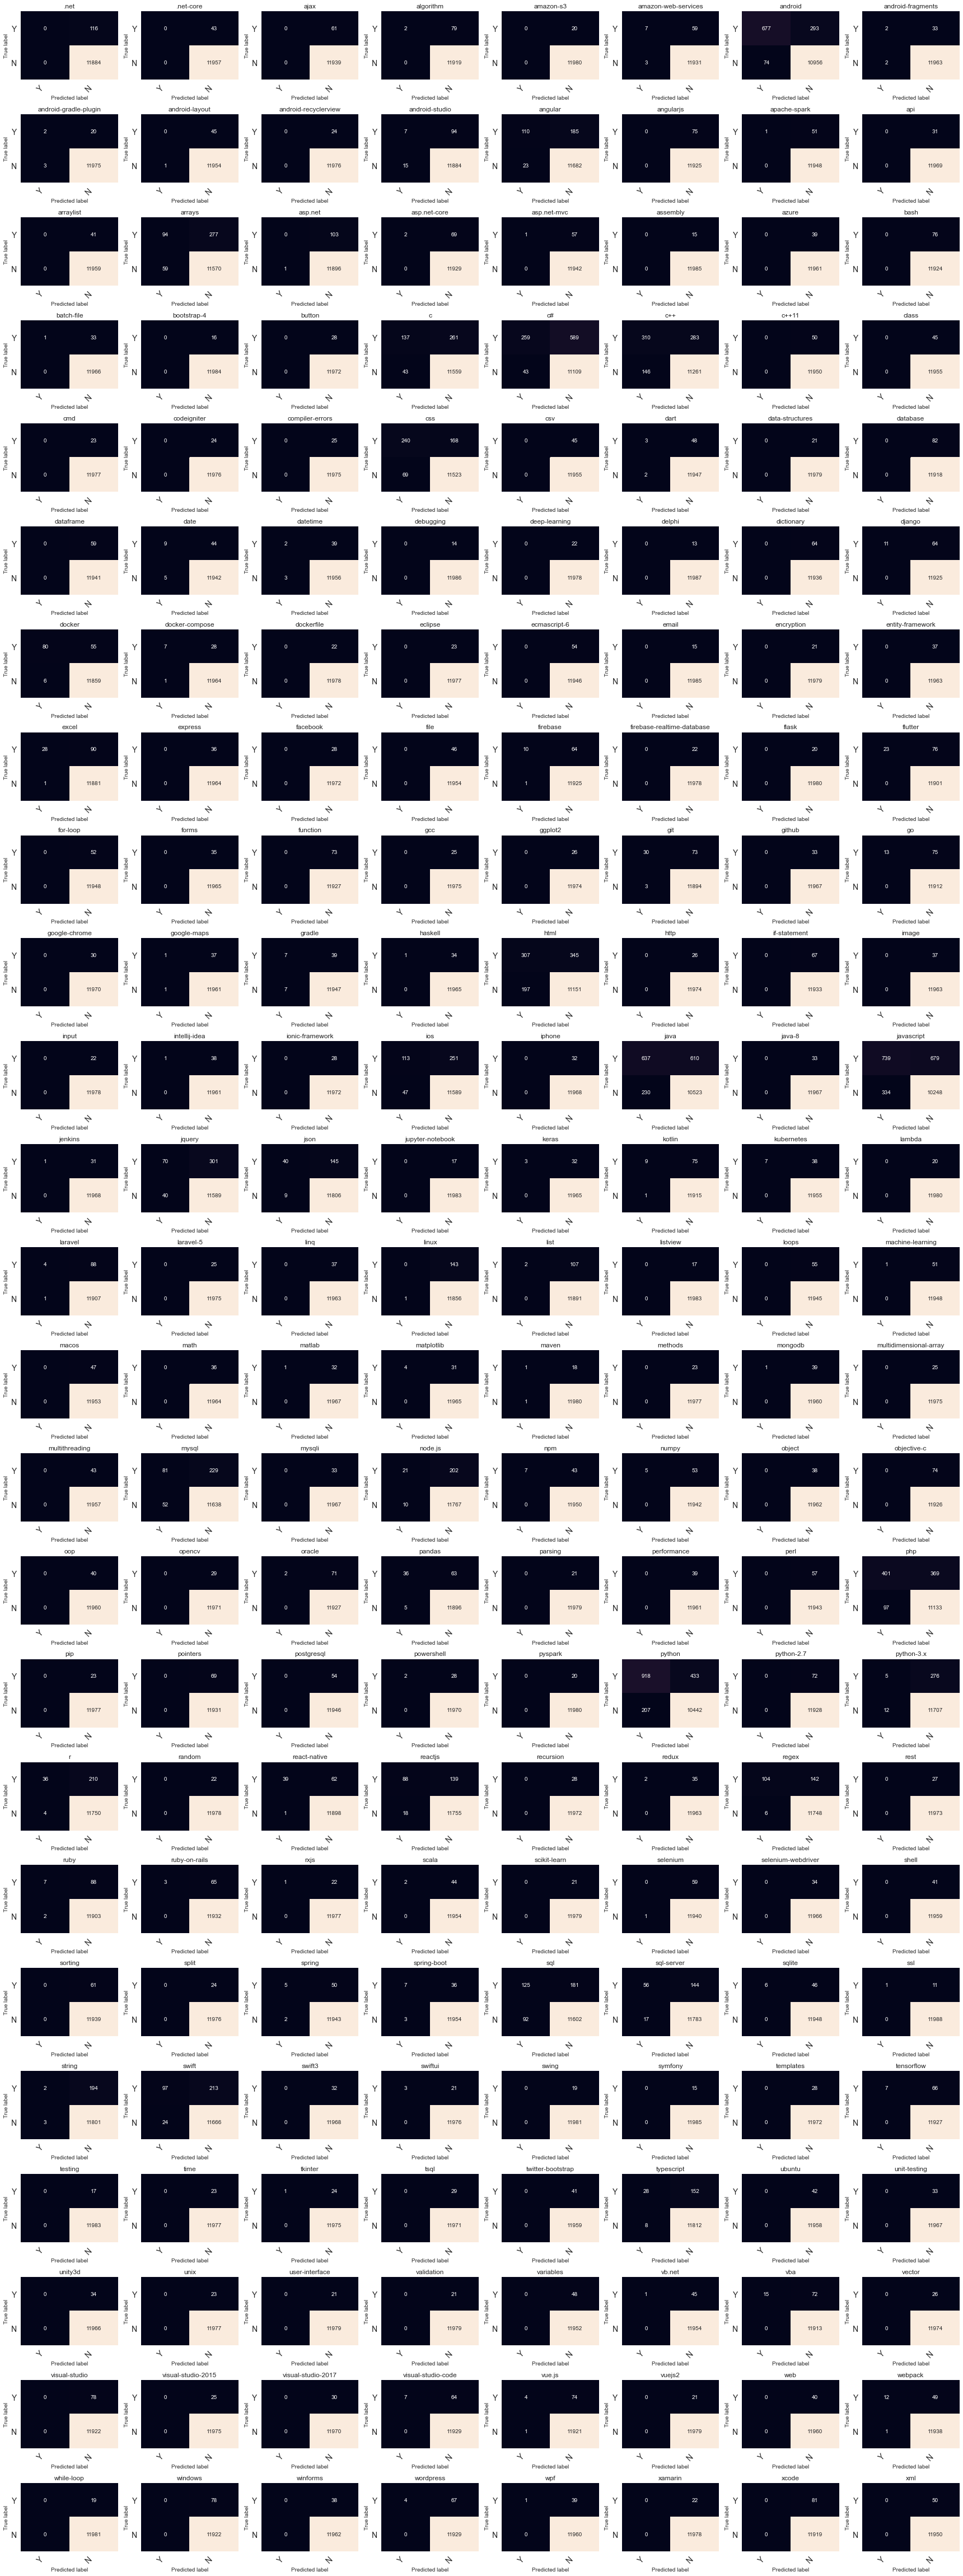

Wall time: 7min 55s


In [52]:
%%time

fig, ax = plt.subplots(25, 8, figsize=(24, 64))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
fig.tight_layout()
plt.show()